# Sistema de Recomendação de Animes

## Definição do Problema

<p>
A similaridade de animes com base no padrão de avaliação dos usuários refere-se à medida de quão semelhantes são os animes com base nas avaliações dadas pelos usuários. Essa abordagem leva em consideração as preferências dos usuários e busca encontrar animes que tenham sido avaliados de maneira semelhante pelos usuários.

Existem várias técnicas que podem ser usadas para calcular a similaridade entre os animes com base nas avaliações dos usuários. Neste projeto Usaremos a abordagem de:

Similaridade de Cosseno: Essa medida calcula a similaridade entre dois vetores de avaliação dos usuários, considerando o ângulo entre eles. Quanto menor o ângulo, maior a similaridade entre os animes.


É importante ressaltar que a escolha da medida de similaridade depende do contexto e das características dos dados disponíveis. Além disso, a qualidade das avaliações dos usuários e a quantidade de dados disponíveis também influenciam os resultados do cálculo da similaridade.

Com base nas medidas de similaridade calculadas, é possível criar um sistema de recomendação que sugere animes semelhantes com base nas avaliações dos usuários. Isso permite que os usuários descubram animes com padrões de avaliação semelhantes aos deles, aumentando a probabilidade de apreciarem as sugestões oferecidas pelo sistema.
</p>

Objetivos:

1. Desenvolver um sistema de similaridade de animes de acordo com o padrão de avaliação dos usuários



## Fonte de Dados

<p>
A myanimelist.net forneceu muitos dados de classificação de varios animes.Este conjunto de dados contém informações sobre os dados de preferência do usuário de 73.516 usuários em 12.294 animes.
</p>

<ul>
<li> <a href="https://www.myanimelist.net">MyAnimeList</a></li>
<li> <a href="https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database">Dataset</a></li>

## Instalando e Carregando os Pacotes

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# Formatação dos gráficos
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

## Carregando os Dados


In [2]:
print("Criando o dataframe pandas a partir do arquivo dados...")
df_animes = pd.read_csv('dados/rating.csv', sep = ',')
print('Concluído.')

Criando o dataframe pandas a partir do arquivo dados.csv...
Concluído.


In [3]:
# Shape
df_animes.shape

(7813737, 3)

In [4]:
df_animes = df_animes[df_animes['rating'] != -1]

In [5]:
# Shape
df_animes.shape

(6337241, 3)

In [6]:
# Visualizando os dados
df_animes.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


## Análise Exploratória dos Dados

In [7]:
# Resumo dos dados
print("Resumo dos Dados")
print("-"*50)
print("Número Total de Animes:", len(np.unique(df_animes.anime_id)))
print("Número Total de Usuários:", len(np.unique(df_animes.user_id)))
print("Número Total de Avaliações:", df_animes.shape[0])

Resumo dos Dados
--------------------------------------------------
Número Total de Animes: 9927
Número Total de Usuários: 69600
Número Total de Avaliações: 6337241


In [8]:
# Vamos salvar esses dois valores para usar mais tarde
total_users = len(np.unique(df_animes.user_id))
total_animes = len(np.unique(df_animes.anime_id))

In [9]:
# Verificando a média das avaliações
df_animes.describe()['rating']

count    6.337241e+06
mean     7.808497e+00
std      1.572496e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [10]:
# Verificando se temos valores ausentes
sum(df_animes.isnull().any())

0

In [11]:
# Verificando se temos valores duplicados (para esse caso não consideramos a data)
sum(df_animes.duplicated(['anime_id', 'user_id', 'rating']))

1

In [12]:
df_animes.drop_duplicates(['anime_id', 'user_id', 'rating'], inplace=True)

In [13]:
# Verificando se temos valores duplicados (para esse caso não consideramos a data)
sum(df_animes.duplicated(['anime_id', 'user_id', 'rating']))

0

In [14]:
# Resumo dos dados de treino
print("Resumo dos Dados de Treino")
print("-"*50)
print("Número Total de Animes:", len(np.unique(df_animes.anime_id)))
print("Número Total de Usuários:", len(np.unique(df_animes.user_id)))
print("Número Total de Avaliações:", df_animes.shape[0])

Resumo dos Dados de Treino
--------------------------------------------------
Número Total de Animes: 9927
Número Total de Usuários: 69600
Número Total de Avaliações: 6337240


A função abaixo vai ajustar as medidas em milhares, milhões e bilhões para facilitar a leitura dos gráficos.

In [15]:
# Função para ajuste das unidades de medida
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [16]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

__Vamos verificar a distribuição das avaliações.__

<IPython.core.display.Javascript object>


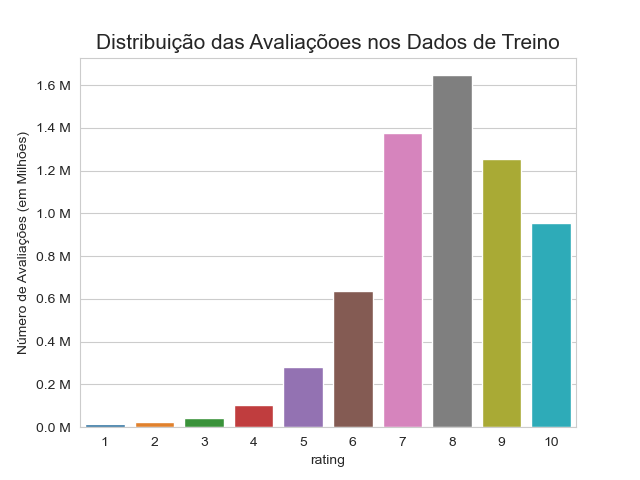

In [17]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribuição das Avaliaçõoes nos Dados de Treino', fontsize = 15)
sns.countplot(df_animes.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Número de Avaliações (em Milhões)')
plt.show()

__Vamos verificar os usuários que mais fizeram avaliações de Animes.__

In [18]:
# Número de avaliações por usuário
num_aval_por_user = df_animes.groupby(by = 'user_id')['rating'].count().sort_values(ascending = False)
num_aval_por_user.head()

user_id
42635    3747
53698    2905
57620    2689
59643    2632
51693    2621
Name: rating, dtype: int64

In [19]:
# Resumo estatístico
num_aval_por_user.describe()

count    69600.000000
mean        91.052299
std        135.764253
min          1.000000
25%         13.000000
50%         45.000000
75%        114.000000
max       3747.000000
Name: rating, dtype: float64

__Vamos criar um plot da função de função de densidade de probabilidade e da função de distribuição acumulada.__

A função de densidade de probabilidade (pdf) e função de distribuição acumulada (cdf) são duas das funções estatísticas mais importantes em confiabilidade e estão intimamente relacionadas. Quando essas funções são conhecidas, quase qualquer outra medida de confiabilidade de interesse pode ser derivada ou obtida. Mais sobre isso aqui:

http://reliawiki.org/index.php/Basic_Statistical_Background

<IPython.core.display.Javascript object>


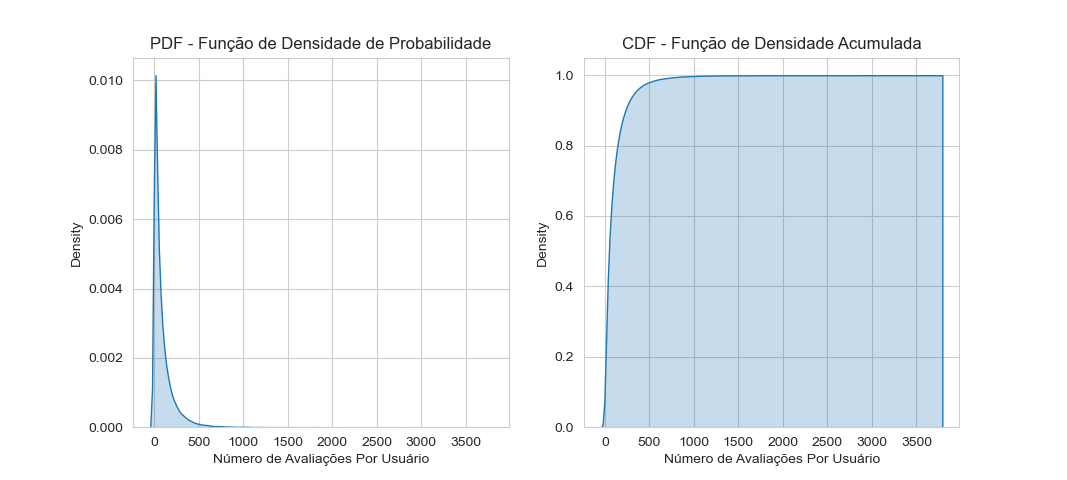

In [20]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax1 = plt.subplot(121)
sns.kdeplot(num_aval_por_user, shade = True, ax = ax1)
plt.xlabel('Número de Avaliações Por Usuário')
plt.title("PDF - Função de Densidade de Probabilidade")
ax2 = plt.subplot(122)
sns.kdeplot(num_aval_por_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Número de Avaliações Por Usuário')
plt.title('CDF - Função de Densidade Acumulada')
plt.show()

Observe que a grande maioria dos usuários tem menos de 500 avaliações.

## Criação de Matriz Esparsa

### Criação da Matriz Esparsa

In [21]:
# Criamos a matriz esparsa no formato Numpy caso não exista
# Se existir, apenas carregamos a partir do disco
if os.path.isfile('dados/matriz_esparsa.npz'):
    matriz_esparsa = sparse.load_npz('dados/matriz_esparsa.npz')
    print("Matriz Carregada.")
else: 
    matriz_esparsa = sparse.csr_matrix((df_animes.rating.values, (df_animes.user_id.values, 
                                                                                 df_animes.anime_id.values)),)
    print('Matriz Criada. O shape é: (user_id, anime_id): ', matriz_esparsa.shape)
    sparse.save_npz("dados/matriz_esparsa.npz", matriz_esparsa)
    print('Matriz Salva em Disco.')

Matriz Criada. O shape é: (user_id, anime_id):  (73517, 34476)
Matriz Salva em Disco.


In [22]:
# Calculamos a esparsidade da matriz
linhas, colunas = matriz_esparsa.shape
elementos_nao_zero = matriz_esparsa.count_nonzero()
print("Esparsidade da Matriz de Treino: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da Matriz de Treino: 99.74996828774361 % 


__Vamos calcular a média global de todas as avaliações de animes, avaliação média por usuário e avaliação média por anime.__

In [23]:
# Abaixo calculamos a média global de todas as avaliações de usuários.
medias = dict()
medias_global = matriz_esparsa.sum() / matriz_esparsa.count_nonzero()
medias['global'] = medias_global
medias

{'global': 7.808504309608892}

__Vamos construir uma função para o cálculo da média de avaliações.__

In [24]:
# Função de cálculo da média
def calcula_media_avaliacoes(sparse_matrix, of_users):
    
    # Média de avaliações de usuários/eixos
    # 1 = eixo de usuário
    # 0 = eixo de anime
    ax = 1 if of_users else 0

    # Soma
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Matriz booleana de avaliações ( se um usuário avaliou um anime ou não )
    is_rated = sparse_matrix!=0
    
    # Número de avaliações de cada usuário ou anime
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # Ids máximos de usuário e anime na matriz esparsa
    u, m = sparse_matrix.shape
    
    # Criamos um dicionário de usuários e suas avaliações médias.
    media_aval = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}

    # Retorna o dicionário de médias de avaliações
    return media_aval

__Abaixo calculamos a média de avaliações por usuário.__

In [25]:
# Média de avaliações de usuários
medias['user'] = calcula_media_avaliacoes(matriz_esparsa, of_users = True)

In [27]:
# Print
print('Média de Avaliação do Usuário 149 :', medias['user'][149])

Média de Avaliação do Usuário 149 : 8.909090909090908


__Abaixo calculamos a média de avaliações por anime.__

In [28]:
# Média de avaliações por anime
medias['anime'] =  calcula_media_avaliacoes(matriz_esparsa, of_users = False)

In [29]:
# Print
print('Avaliação Média do anime 32 :', medias['anime'][32])

Avaliação Média do anime 32 : 8.405749293119698


__PDFs e CDs da média. Avaliações de usuários e animes (dados de treino).__

<IPython.core.display.Javascript object>


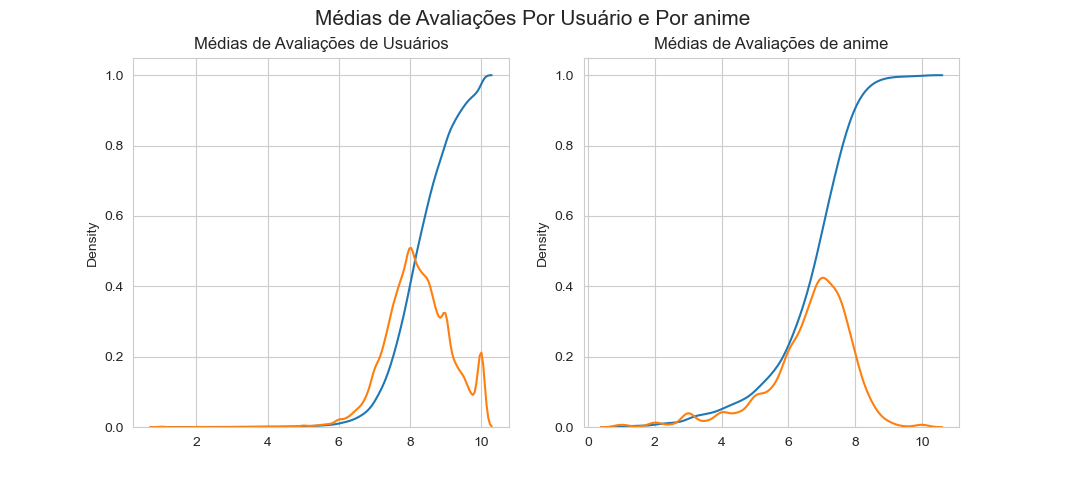

In [30]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.45))
fig.suptitle('Médias de Avaliações Por Usuário e Por anime', fontsize = 15)

ax1.set_title('Médias de Avaliações de Usuários')

# Obtemos a lista de avaliações médias do usuário no dicionário de médias.
medias_usuarios = [rat for rat in medias['user'].values()]
sns.distplot(medias_usuarios, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_usuarios, ax = ax1, hist = False, label = 'PDF')

ax2.set_title('Médias de Avaliações de anime')

# Obtemos a lista de avaliações médias de animes do dicionário.
medias_anime = [rat for rat in medias['anime'].values()]
sns.distplot(medias_anime, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_anime, ax = ax2, hist = False, label = 'PDF')

plt.show()

## Calculando a Matriz de Similaridade de Usuários

In [31]:
# Função de cálculo de similaridade
def calcula_similaridade_usuario(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    # Variáveis de controle
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculando top", top, "similaridades para cada usuário...")
    start = datetime.now()
    temp = 0
    
    # Loop pela matriz
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculando a similaridade de cosseno
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Cálculo concluído para {} usuários [  tempo total : {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Criação de matriz esparsa a partir das semelhanças computadas...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Tempo de cálculo de cada usuário')
        plt.plot(np.cumsum(time_taken), label = 'Tempo Total')
        plt.legend(loc = 'best')
        plt.xlabel('Usuário')
        plt.ylabel('Tempo (segundos)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken      

Calculando top 100 similaridades para cada usuário...
Cálculo concluído para 20 usuários [  tempo total : 0:00:04.087736  ]
Cálculo concluído para 40 usuários [  tempo total : 0:00:08.086996  ]
Cálculo concluído para 60 usuários [  tempo total : 0:00:11.960622  ]
Cálculo concluído para 80 usuários [  tempo total : 0:00:15.828236  ]
Cálculo concluído para 100 usuários [  tempo total : 0:00:19.694853  ]
Criação de matriz esparsa a partir das semelhanças computadas...


<IPython.core.display.Javascript object>


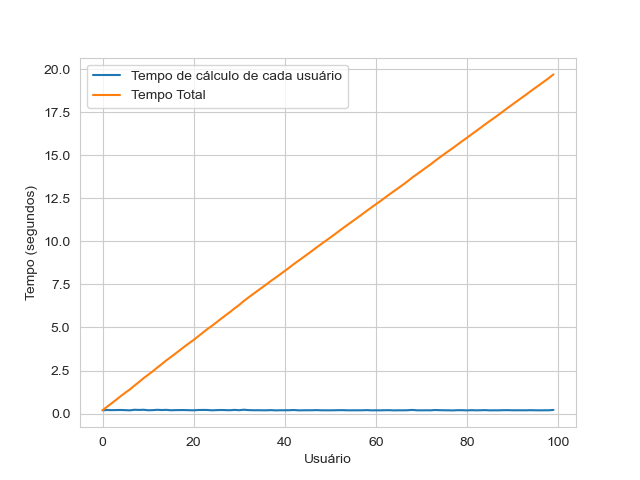

Tempo Total de Processamento: 0:00:20.145934


In [32]:
# Calculamos a similaridade

# Marca o início
start = datetime.now()

# Calcula a similaridade
matriz_esparsa_user, _ = calcula_similaridade_usuario(matriz_esparsa, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print("Tempo Total de Processamento:", datetime.now() - start)

In [33]:
matriz_esparsa_user.shape

(73517, 73517)

In [34]:
# Tipo
type(matriz_esparsa_user)

scipy.sparse._csr.csr_matrix

In [35]:
# Vamos criar e salvar em disco a matriz com a a dimensionalidade reduzida para 500 dimensões
if not os.path.isfile('dados/matriz_esparsa_user.npz'):
    matriz_esparsa_user = sparse.csr_matrix(matriz_esparsa_user)
    sparse.save_npz('dados/matriz_esparsa_user', matriz_esparsa_user)
else:
    matriz_esparsa_user = sparse.load_npz('dados/matriz_esparsa_user.npz')

In [36]:
# Conferindo o shape
matriz_esparsa_user.shape

(73517, 73517)

__Agora calculamos novamente a similaridade de usuários usando a matriz truncada.__

Calculando top 50 similaridades para cada usuário...
Cálculo concluído para 20 usuários [  tempo total : 0:00:00.046902  ]
Cálculo concluído para 40 usuários [  tempo total : 0:00:00.086795  ]
Criação de matriz esparsa a partir das semelhanças computadas...


<IPython.core.display.Javascript object>


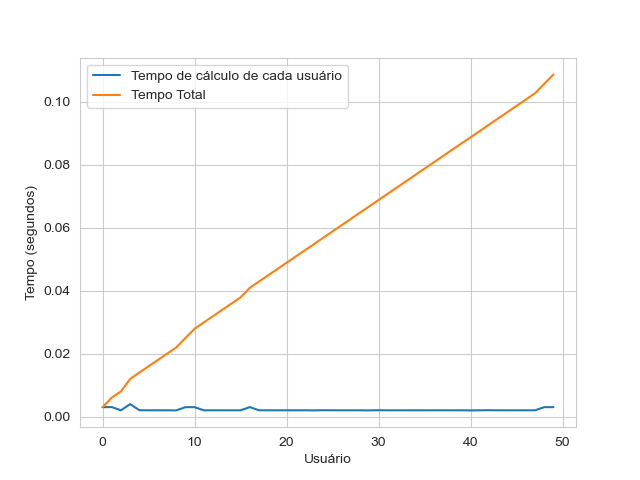

Tempo de Processamento: 0:00:00.132644


In [37]:
# Calcula similaridade de usuários

# Marca o início
start = datetime.now()

# Calcula a similaridade
trunc_sim_matrix, _ = calcula_similaridade_usuario(matriz_esparsa_user, 
                                                   compute_for_few = True, 
                                                   top = 50, 
                                                   verbose = True) 

print("Tempo de Processamento:", datetime.now() - start)

## Calculando Matriz de Similaridade de Animes

In [38]:
# Cálculo da similaridade de Animes

# Marca o início
start = datetime.now()

# Cria se não existir
if not os.path.isfile('dados/matriz_esparsa_anime.npz'):
    matriz_esparsa_anime = cosine_similarity(X = matriz_esparsa.T, dense_output = False)
    print("Matriz Criada.")
    sparse.save_npz("dados/matriz_esparsa_anime.npz", matriz_esparsa_anime)
    print("Matriz Salva em Disco.")
else:
    matriz_esparsa_anime = sparse.load_npz("dados/matriz_esparsa_anime.npz")
    print("Matriz Carregada.")

print("Tempo de Processamento:", datetime.now() - start)

Matriz Criada.
Matriz Salva em Disco.
Tempo de Processamento: 0:00:47.503505


In [39]:
# Shape
matriz_esparsa_anime.shape

(34476, 34476)

In [40]:
df_similarities = pd.DataFrame(matriz_esparsa_anime.toarray())

In [41]:
df_similarities.head(10)

,0,1,2,3,4,5,6,7,8,9,...,34466,34467,34468,34469,34470,34471,34472,34473,34474,34475
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.000000,0.0,0.0,0.0,0.607757,0.534823,0.256910,0.071918,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011319
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.607757,0.0,0.0,0.0,1.000000,0.413588,0.250765,0.059980,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005825
6,0.0,0.534823,0.0,0.0,0.0,0.413588,1.000000,0.273966,0.096445,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007739
7,0.0,0.256910,0.0,0.0,0.0,0.250765,0.273966,1.000000,0.082593,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.071918,0.0,0.0,0.0,0.059980,0.096445,0.082593,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [42]:
# Extrai os ids dos animes
animes_ids = np.unique(matriz_esparsa_anime.nonzero()[1])

In [43]:
# Calcula a similaridade de animes de acordo com o padrão de avaliação dos usuários

# Marca o início
start = datetime.now()

# Dicionário para armazenar as similaridades
animes_similares = dict()

# Loop pelos ids dos animes
for animes in animes_ids:
    # Obtemos os top animes semelhantes e armazenamos no dicionário
    animes_sim = matriz_esparsa_anime[animes].toarray().ravel().argsort()[::-1][1:]
    animes_similares[animes] = animes_sim[:100]
    
print("Tempo de Processamento:", datetime.now() - start)

Tempo de Processamento: 0:00:10.226283


In [44]:
# Animes similares ao Animes de id 5
animes_similares[5]

array([   1,   43,   47,    6,  205,  227,   30,  467,  164,   32,  468,
        889,  801, 1519,  199, 1943,  572, 2251,  121, 2001,  430, 2759,
        431,  617,  849, 4106,  270, 2236,  543,  405,   44, 1566,   71,
        437,   33,  400,  317,  790,  339, 1210, 3784,  570,   72,  323,
        513,   31,  578,  523, 2025, 5681,  457,   97,  759, 1575,  245,
       4037, 2418,  512, 1303,   73,   66, 6675,  565,   54, 3901,  202,
       1689,  208,  267, 1535,  226,  237,  268, 1292, 5630,  522, 2904,
        416,  134,   45,  182, 1033,  732, 1818, 2593,  240,  387, 5114,
        256,    7, 4901, 1361,  393,  433, 3782, 2605,   57,  379, 2966,
        401], dtype=int64)

__Agora vamos encontrar os animes mais semelhantes usando a matriz de similaridade.__

In [45]:
# Vamos carregar os títulos dos animes do arquivo csv fornecido pela Netflix
titulos_animes = pd.read_csv("dados/anime.csv", 
                             sep = ',', 
                             header = 0,
                             names = ['anime_id', 'name', 'genre','type','episodes','rating','members'], 
                             verbose = True,
                             index_col = 'anime_id', 
                             encoding = "ISO-8859-1")

Tokenization took: 5.94 ms
Type conversion took: 9.83 ms
Parser memory cleanup took: 0.00 ms


In [46]:
# Visualiza os dados
titulos_animes.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,GintamaÂ°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


__Vejamos quais são os animes similares ao anime de ID 5.__

In [47]:
# ID do anime
id_anime = 5

In [48]:
# Print
print("Anime:", titulos_animes.loc[id_anime].values[0])
print("Total de Avaliações de Usuários = {}.".format(matriz_esparsa[:,id_anime].getnnz()))
print("Encontramos {} Animes que são similares a este e vamos imprimir os mais similares.".format(matriz_esparsa_anime[:,id_anime].getnnz()))

Anime: Cowboy Bebop: Tengoku no Tobira
Total de Avaliações de Usuários = 5790.
Encontramos 9336 Animes que são similares a este e vamos imprimir os mais similares.


In [49]:
# Encontrando todas as similaridades
similarities = matriz_esparsa_anime[id_anime].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] 

<IPython.core.display.Javascript object>


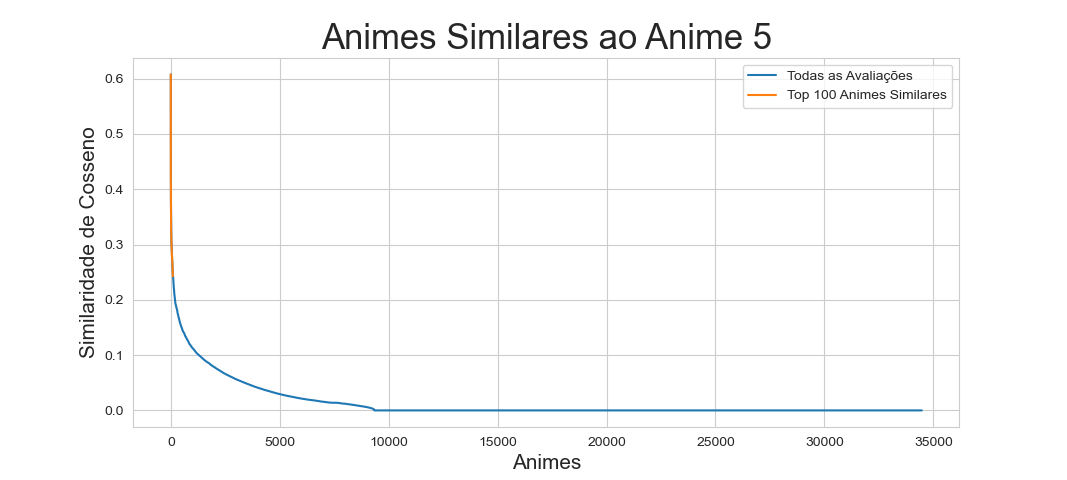

In [50]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similarities[sim_indices], label = 'Todas as Avaliações')
plt.plot(similarities[sim_indices[:100]], label = 'Top 100 Animes Similares')
plt.title("Animes Similares ao Anime {}".format(id_anime), fontsize = 25)
plt.xlabel("Animes", fontsize = 15)
plt.ylabel("Similaridade de Cosseno", fontsize = 15)
plt.legend()
plt.show()

In [51]:
# Aqui os top 10 animes mais similares ao anime 5
titulos_animes.loc[sim_indices[:10]]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
43,Ghost in the Shell,"Action, Mecha, Police, Psychological, Sci-Fi, ...",Movie,1,8.34,223036
47,Akira,"Action, Adventure, Horror, Military, Sci-Fi, S...",Movie,1,8.15,215897
6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069
205,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",TV,26,8.50,390076
227,FLCL,"Action, Comedy, Dementia, Mecha, Parody, Sci-Fi",OVA,6,8.06,305165
30,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,26,8.32,461946
467,Ghost in the Shell: Stand Alone Complex,"Action, Mecha, Military, Police, Sci-Fi, Seinen",TV,26,8.47,194491
164,Mononoke Hime,"Action, Adventure, Fantasy",Movie,1,8.81,339556


Já poderíamos concluir o projeto aqui, pois já temos um sistema de recomendação.

# Fim